In [344]:
import os, sys
import argparse
import copy

import numpy as np
import healpy as hp
from iminuit import Minuit
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import *
from scipy.integrate import quad
from scipy.interpolate import interp1d

# # Fermi plugin modules
# sys.path.append("/group/hepheno/heptools/Fermi-NPTF-exposure/") 
# import fermi.fermi_plugin as fp

# NPTFit modules
# from NPTFit import nptfit # module for performing scan
# from NPTFit import create_mask as cm # module for creating the mask
# from NPTFit import dnds_analysis # module for analysing the output

# # Modules to make extended DM map
# sys.path.append('/group/hepheno/smsharma/Fermi-LSS/mkDMMaps//')
# import NFW
# import mkDMMaps

%matplotlib inline

In [345]:
xsecs = np.logspace(-33,-18,301)
marr = np.array([1.00000000e+01,1.50000000e+01,2.00000000e+01,2.50000000e+01,3.00000000e+01,4.00000000e+01,5.00000000e+01,6.00000000e+01,7.00000000e+01,8.00000000e+01,9.00000000e+01,1.00000000e+02,1.10000000e+02,1.20000000e+02,1.30000000e+02,1.40000000e+02,1.50000000e+02,1.60000000e+02,1.80000000e+02,2.00000000e+02,2.20000000e+02,2.40000000e+02,2.60000000e+02,2.80000000e+02,3.00000000e+02,3.30000000e+02,3.60000000e+02,4.00000000e+02,4.50000000e+02,5.00000000e+02,5.50000000e+02,6.00000000e+02,6.50000000e+02,7.00000000e+02,7.50000000e+02,8.00000000e+02,9.00000000e+02,1.00000000e+03,1.10000000e+03,1.20000000e+03,1.30000000e+03,1.50000000e+03,1.70000000e+03,2.00000000e+03,2.50000000e+03,3.00000000e+03,4.00000000e+03,5.00000000e+03,6.00000000e+03,7.00000000e+03,8.00000000e+03,9.00000000e+03,1.00000000e+04])

In [321]:
# Catalog used for the analysis (e.g. 2MASS or DarkSky)
catalog_file = '/tigress/bsafdi/github/NPTF-working/NPTF-ID-Catalog/data/Catalogs/DarkSky_ALL_200,200,200_v3.csv'

# Cuts
halos_to_keep = 100 # total number of halos to keep
bcut = 20 # latitude cut
cut_0p5 = False # cut halos within 0.5 degrees of a 3FGL source
nonoverlap = False # whether to insist on non-overlapping regions
nonoverlapradius = 2 # radius of non-overlapping region

# Default TS xsec parameters
TS100 = 5
TS1000 = 9
TSabove = 16
xsecslim = 10

In [322]:
# Define the xsec and mass array, these should be the same as used during the runs
xsecs = np.logspace(-33,-18,301)
marr = np.array([1.00000000e+01,1.50000000e+01,2.00000000e+01,2.50000000e+01,3.00000000e+01,
                 4.00000000e+01,5.00000000e+01,6.00000000e+01,7.00000000e+01,8.00000000e+01,
                 9.00000000e+01,1.00000000e+02,1.10000000e+02,1.20000000e+02,1.30000000e+02,
                 1.40000000e+02,1.50000000e+02,1.60000000e+02,1.80000000e+02,2.00000000e+02,
                 2.20000000e+02,2.40000000e+02,2.60000000e+02,2.80000000e+02,3.00000000e+02,
                 3.30000000e+02,3.60000000e+02,4.00000000e+02,4.50000000e+02,5.00000000e+02,
                 5.50000000e+02,6.00000000e+02,6.50000000e+02,7.00000000e+02,7.50000000e+02,
                 8.00000000e+02,9.00000000e+02,1.00000000e+03,1.10000000e+03,1.20000000e+03,
                 1.30000000e+03,1.50000000e+03,1.70000000e+03,2.00000000e+03,2.50000000e+03,
                 3.00000000e+03,4.00000000e+03,5.00000000e+03,6.00000000e+03,7.00000000e+03,
                 8.00000000e+03,9.00000000e+03,1.00000000e+04])

# Load the catalog and extract the b values for the latitude cut, l for the ROI cut (if specified),
# apply 0p5 cut if required
catalog = pd.read_csv(catalog_file)[:halos_to_keep]
b_array = catalog.b.values
ell_array = catalog.l.values
near_3FGL = np.array([ len(catalog[u'3FGL 0.5'].values[i]) for i in range(len(b_array))])

if cut_0p5:
    good_vals = np.where((np.abs(b_array) > bcut) & (near_3FGL == 2))[0]
else:
    good_vals = np.where(np.abs(b_array) > bcut)[0]

good_halos = len(good_vals)

# e-LL-ephant

In [323]:
midx = 11
nmc = 100

4it [00:02,  1.82it/s]


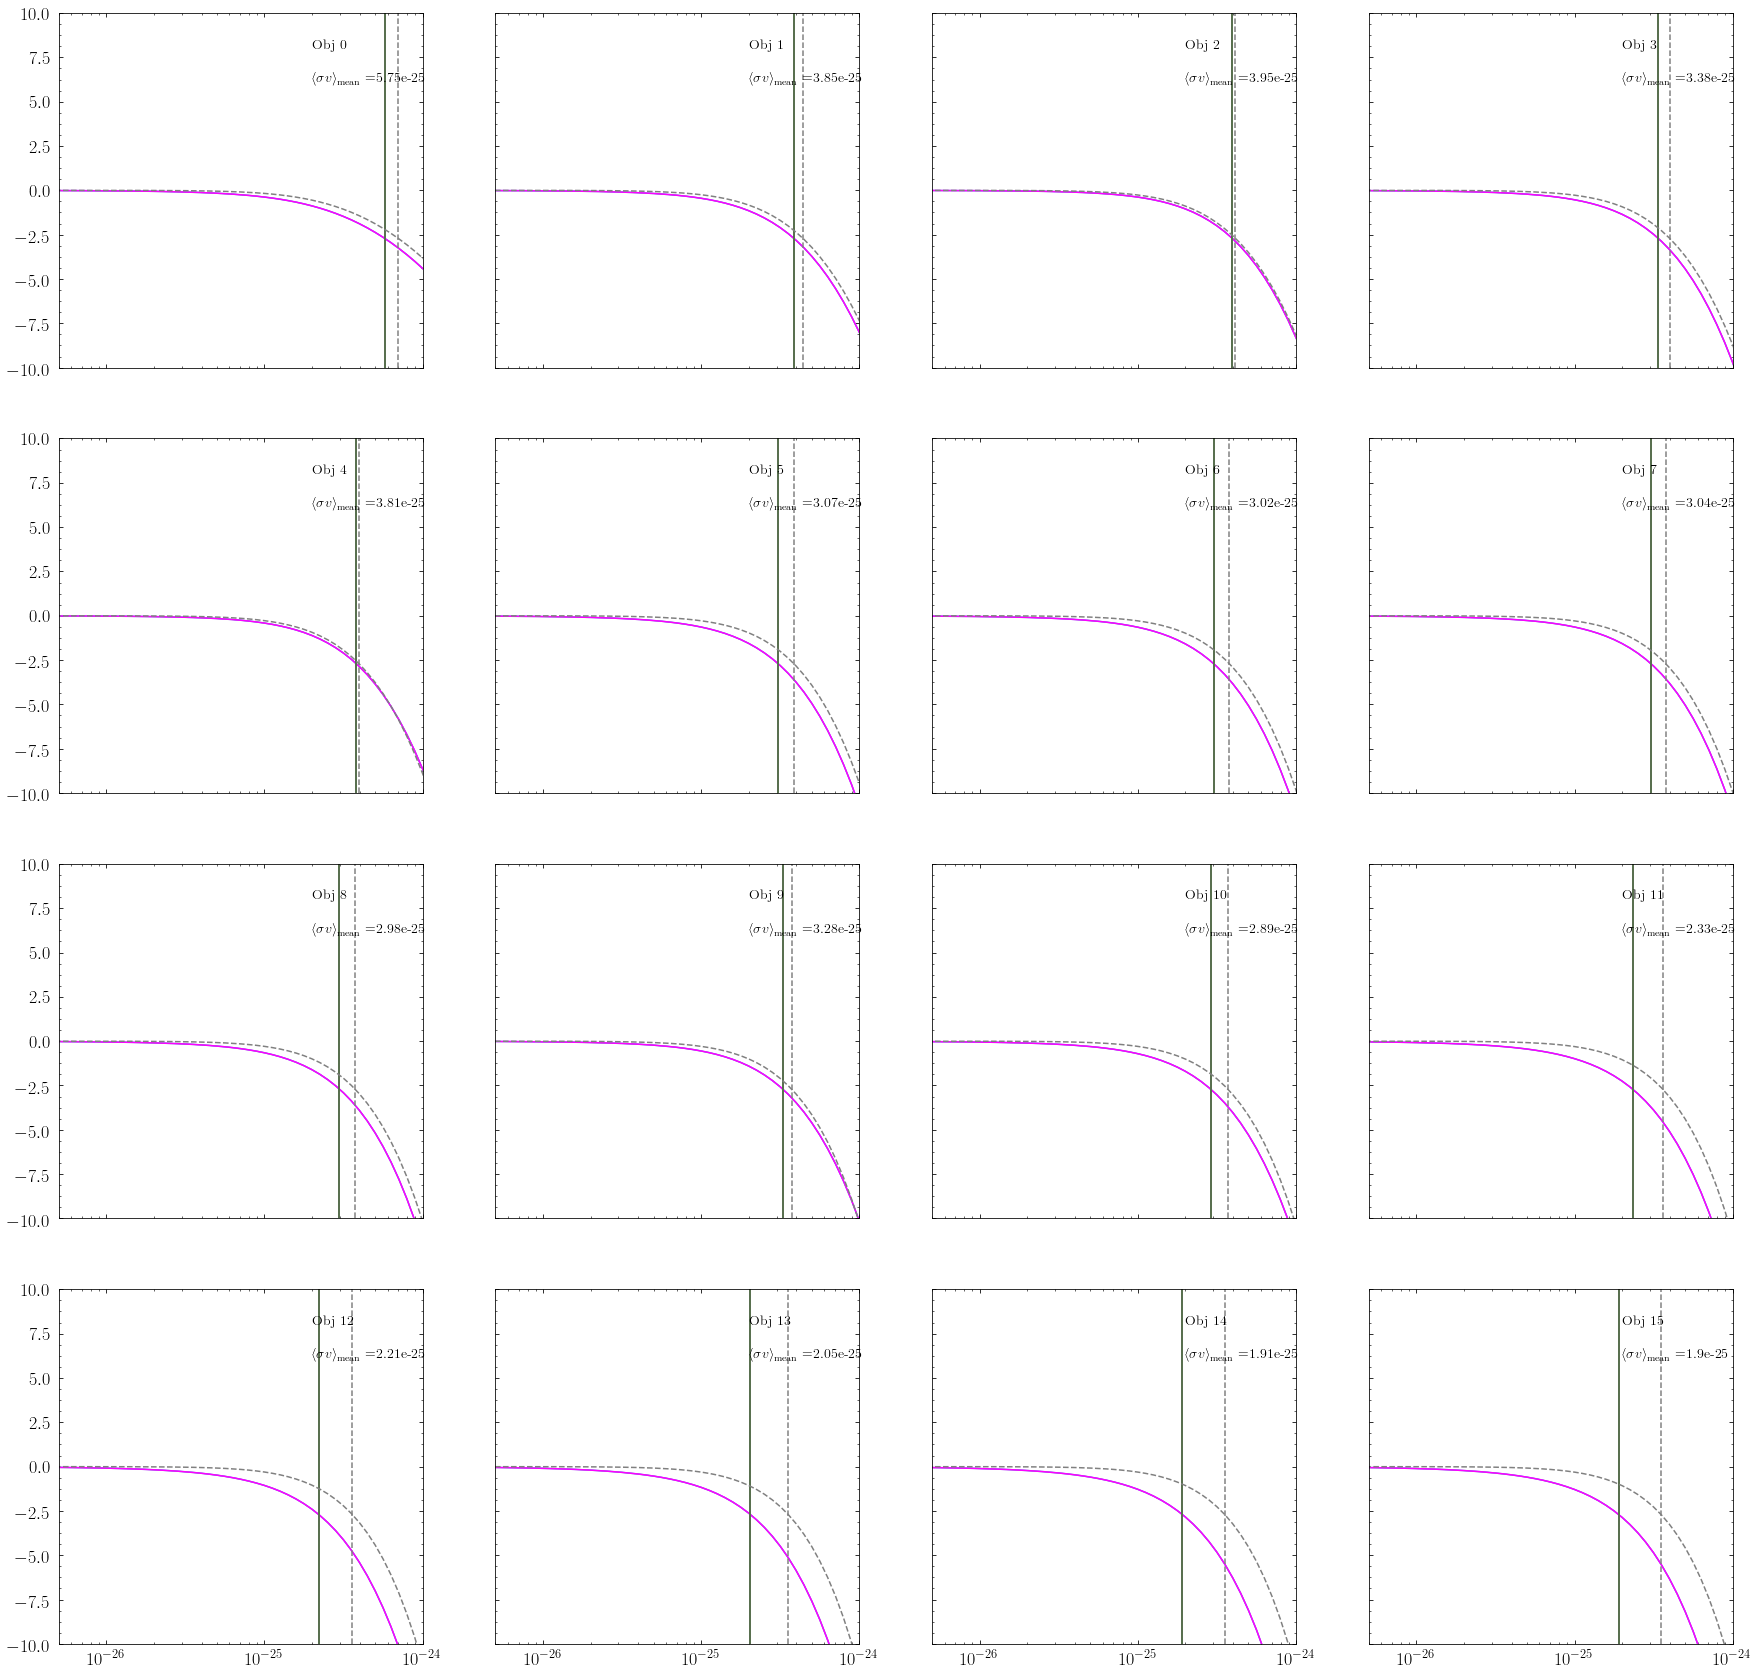

In [343]:
ncols=4
nrows=4

fig, axes2d = plt.subplots(nrows=nrows, ncols=ncols,
                           sharex=True, sharey=True,
                           figsize=(30/1.,30/1.))


LL_ary = np.zeros((nmc, len(xsecs)))
LL_ary_asim = np.zeros((1, len(xsecs)))

Nh_ary = np.arange(ncols*nrows)
limit_Nh = np.zeros((nmc, ncols*nrows))

good_vals = Nh_ary

LL_add_means = np.zeros((len(xsecs)))

for i, row in tqdm(enumerate(axes2d)):
    for j, cell in enumerate(row):
        obj = i*ncols + j

        LL_ary_plot = np.zeros((nmc, len(xsecs)))
        limit_total = np.zeros(nmc)
        for imc in (range(nmc)):
            good_obj = True 
            if obj in good_vals:
                    LL_ary[imc] += np.load('data/FloatPS_together_noDM_1overJ//////////////LL2_TSmx_lim_b_o'+str(obj)+'_mc'+str(imc)+'.npz')['LL2'][midx]      
            else:
                good_obj = False
            
            LL_ary_plot[imc] = LL_ary[imc] - LL_ary[imc][0]

            max_arg = np.argmax(LL_ary_plot[imc])
            max_val = LL_ary_plot[imc][max_arg]

            for xi in range(max_arg,len(xsecs)):
                val = LL_ary_plot[imc][xi]-max_val
                if val < -2.71:
                    scale = (LL_ary_plot[imc][xi-1]-max_val+2.71)/(LL_ary_plot[imc][xi-1]-LL_ary_plot[imc][xi])
                    limit_total[imc] = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
                    break
        
        LL_plot = np.percentile(LL_ary_plot, [2.5,16,50,84,97.5], axis=0)
        LL_plot_mean = np.mean(LL_ary_plot, axis=0)

        LL_add_means = np.mean(LL_ary_plot, axis=0)

        limit_plot = np.percentile(limit_total, [2.5,16,50,84,97.5])
        limit_plot_mean = np.mean(limit_total)
        limit_plot_mean_of_logs = np.exp(np.mean(np.log(limit_total)))



        limit_Nh[:,obj] = limit_total 
        
        cell.plot(xsecs,LL_plot[2], color='cornflowerblue')
        cell.plot(xsecs,LL_plot_mean, color='magenta')


        cell.fill_between(xsecs,LL_plot[1],LL_plot[3], alpha=0.5, color='cornflowerblue')
        cell.fill_between(xsecs,LL_plot[0],LL_plot[4], alpha=0.2, color='cornflowerblue')
        cell.axvspan(limit_plot[1],limit_plot[3], alpha=0.2, color='tomato')
        cell.axvline(limit_plot[2], color='tomato', ls='-')


        cell.axvline(limit_plot_mean, color='magenta', ls='-')
        cell.axvline(limit_plot_mean_of_logs, color='forestgreen', ls='-')


        
        LL_ary_plot_asim = np.zeros((1, len(xsecs)))
        limit_total_asim = np.zeros(1)
    
        for imc in (range(1)):
            good_obj = True 
            if obj in good_vals:
                    LL_ary_asim[imc] += np.load('data/AsimovProf1overJ//////////////LL2_TSmx_lim_b_o'+str(obj)+'_Asimov.npz')['LL2'][midx]                
            else:
                good_obj = False
            
            LL_ary_plot_asim[imc] = LL_ary_asim[imc] - LL_ary_asim[imc][0]

            max_arg = np.argmax(LL_ary_plot_asim[imc])
            max_val = LL_ary_plot_asim[imc][max_arg]

            for xi in range(max_arg,len(xsecs)):
                val = LL_ary_plot_asim[imc][xi]-max_val
                if val < -2.71:
                    scale = (LL_ary_plot_asim[imc][xi-1]-max_val+2.71)/(LL_ary_plot_asim[imc][xi-1]-LL_ary_plot_asim[imc][xi])
                    limit_total_asim[imc] = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
                    break
        
        LL_plot_asim = np.percentile(LL_ary_plot_asim, [2.5,16,50,84,97.5], axis=0)
        limit_plot_asim = np.percentile(limit_total_asim, [2.5,16,50,84,97.5])
        limit_Nh[:,obj] = limit_total 
        
        cell.plot(xsecs,LL_plot_asim[2], color='grey',ls='--')
        cell.axvline(limit_plot_asim[2], color='grey', ls='--')




        cell.set_ylim(-10,10)
        cell.set_xscale("log")
#         cell.set_xlim(1e-27,1e-21)
        cell.set_xlim(5e-27,1e-24)
#         cell.set_xlim(5e-26,1e-19)


        cell.legend(loc='lower left')
        if good_obj:
            cell.text(2*10**-25,8, "Obj " + str(obj), fontsize=14, color='k')
        else:
            cell.text(2*10**-25,8, "Obj " + str(obj), fontsize=14, color='k')
        cell.text(2*10**-25,6, "$\\langle\sigma v\\rangle_{\mathrm{mean}} = $" + "{0:.3g}".format(limit_plot[2]), fontsize=14, color='k')


# Elephant

In [336]:
midx = 11
nmc = 100

In [339]:
LL_ary = np.zeros((nmc, len(xsecs)))

Nh_ary = np.arange(100)
limit_Nh = np.zeros((nmc, 100))


for obj in tqdm(range(100)):

    LL_ary_plot = np.zeros((nmc, len(xsecs)))
    limit_total = np.zeros(nmc)
    for imc in (range(nmc)):
        good_obj = True 
        if 1: #obj in good_vals and obj != 2:
                LL_ary[imc] += np.load('data/FloatPS_together_noDM_1overJ///////////LL2_TSmx_lim_b_o'+str(obj)+'_mc'+str(imc)+'.npz')['LL2'][midx]      
#                 LL_ary[imc] += np.load('data/old/AsimovNoProf/////////LL2_TSmx_lim_b_o'+str(obj)+'_Asimov.npz')['LL2'][midx]                
        else:
            good_obj = False

        LL_ary_plot[imc] = LL_ary[imc] - LL_ary[imc][0]

    LL_median = np.percentile(LL_ary_plot, [50], axis=0)[0]
    max_arg = np.argmax(LL_median)
    max_val = LL_median[max_arg]

    for xi in range(max_arg,len(xsecs)):
        val = LL_median[xi]-max_val
        if val < -2.71:
            scale = (LL_median[xi-1]-max_val+2.71)/(LL_median[xi-1]-LL_median[xi])
            limit_total = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
            break

    LL_plot = LL_median
    limit_plot = limit_total
    limit_Nh[:,obj] = limit_plot 

100%|██████████| 100/100 [04:37<00:00,  1.76s/it]


In [340]:
nmc = 1

LL_ary = np.zeros((nmc, len(xsecs)))

Nh_ary = np.arange(100)
limit_Nh_as = np.zeros((nmc, 100))
limit_Nh_as_2p5 = np.zeros((nmc, 100))
limit_Nh_as_16 = np.zeros((nmc, 100))
limit_Nh_as_84 = np.zeros((nmc, 100))
limit_Nh_as_97p5 = np.zeros((nmc, 100))

limit_Nh_as_test1 = np.zeros((nmc, 100))
limit_Nh_as_test2 = np.zeros((nmc, 100))

limit_Nh_as_test3 = np.zeros((nmc, 100))




for obj in tqdm(range(100)):

    LL_ary_plot = np.zeros((nmc, len(xsecs)))
    limit_total = np.zeros(nmc)
    limit_total_2p5 = np.zeros(nmc)
    limit_total_16 = np.zeros(nmc)
    limit_total_84 = np.zeros(nmc)
    limit_total_97p5 = np.zeros(nmc)

    limit_total_test1 = np.zeros(nmc)
    limit_total_test2 = np.zeros(nmc)
    limit_total_test3 = np.zeros(nmc)



    for imc in (range(nmc)):
        good_obj = True 
        if 1: #obj in good_vals and obj != 2:
#                 LL_ary[imc] += np.load('data/FloatPS_together_noDM///////LL2_TSmx_lim_b_noJprof_o'+str(obj)+'_mc'+str(imc)+'.npz')['LL2'][midx]      
            LL_ary[imc] += np.load('data/AsimovProf1overJ////////////LL2_TSmx_lim_b_o'+str(obj)+'_Asimov.npz')['LL2'][midx]                


        else:
            good_obj = False

        LL_ary_plot_asim[imc] = LL_ary[imc] - LL_ary[imc][0]

        max_arg = np.argmax(LL_ary_plot[imc])
        max_val = LL_ary_plot[imc][max_arg]

        for xi in range(max_arg,len(xsecs)):
            val = LL_ary_plot_asim[imc][xi]-max_val
            if val < -2.71:
                scale = (LL_ary_plot_asim[imc][xi-1]-max_val+2.71)/(LL_ary_plot_asim[imc][xi-1]-LL_ary_plot_asim[imc][xi])
                limit_total[imc] = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
                break

        for xi in range(max_arg,len(xsecs)):
            val = LL_ary_plot_asim[imc][xi]-max_val
            if val < -0.701:
                scale = (LL_ary_plot_asim[imc][xi-1]-max_val+0.701)/(LL_ary_plot_asim[imc][xi-1]-LL_ary_plot_asim[imc][xi])
                limit_total_2p5[imc] = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
                break

        for xi in range(max_arg,len(xsecs)):
            val = LL_ary_plot_asim[imc][xi]-max_val
            if val < -1.3174:
                scale = (LL_ary_plot_asim[imc][xi-1]-max_val+1.3174)/(LL_ary_plot_asim[imc][xi-1]-LL_ary_plot_asim[imc][xi])
                limit_total_16[imc] = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
                break

        for xi in range(max_arg,len(xsecs)):
            val = LL_ary_plot_asim[imc][xi]-max_val
            if val < -5.654:
                scale = (LL_ary_plot_asim[imc][xi-1]-max_val+5.654)/(LL_ary_plot_asim[imc][xi-1]-LL_ary_plot_asim[imc][xi])
                limit_total_84[imc] = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
                break

        for xi in range(max_arg,len(xsecs)):
            val = LL_ary_plot_asim[imc][xi]-max_val
            if val < -10.8545:
                scale = (LL_ary_plot_asim[imc][xi-1]-max_val+10.8545)/(LL_ary_plot_asim[imc][xi-1]-LL_ary_plot_asim[imc][xi])
                limit_total_97p5[imc] = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
                break
                
        for xi in range(max_arg,len(xsecs)):
            val = LL_ary_plot_asim[imc][xi]-max_val
            if val < -6.99525:
                scale = (LL_ary_plot_asim[imc][xi-1]-max_val+6.99525)/(LL_ary_plot_asim[imc][xi-1]-LL_ary_plot_asim[imc][xi])
                limit_total_test1[imc] = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
                break

        for xi in range(max_arg,len(xsecs)):
            val = LL_ary_plot_asim[imc][xi]-max_val
            if val < -13.285:
                scale = (LL_ary_plot_asim[imc][xi-1]-max_val+13.285)/(LL_ary_plot_asim[imc][xi-1]-LL_ary_plot_asim[imc][xi])
                limit_total_test2[imc] = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
                break


        for xi in range(max_arg,len(xsecs)):
            val = LL_ary_plot_asim[imc][xi]-max_val
            if val < -0.415836:
                scale = (LL_ary_plot_asim[imc][xi-1]-max_val+0.415836)/(LL_ary_plot_asim[imc][xi-1]-LL_ary_plot_asim[imc][xi])
                limit_total_test3[imc] = 10**(np.log10(xsecs[xi-1])+scale*(np.log10(xsecs[xi])-np.log10(xsecs[xi-1])))
                break


    LL_plot = np.percentile(LL_ary_plot, [2.5,16,50,84,97.5], axis=0)
    limit_plot = np.percentile(limit_total, [2.5,16,50,84,97.5])
    
    limit_Nh_as[:,obj] = limit_total 
    limit_Nh_as_2p5[:,obj] = limit_total_2p5 
    limit_Nh_as_16[:,obj] = limit_total_16
    limit_Nh_as_84[:,obj] = limit_total_84
    limit_Nh_as_97p5[:,obj] = limit_total_97p5
    limit_Nh_as_test1[:,obj] = limit_total_test1
    limit_Nh_as_test2[:,obj] = limit_total_test2
    limit_Nh_as_test3[:,obj] = limit_total_test3

100%|██████████| 100/100 [00:01<00:00, 51.47it/s]


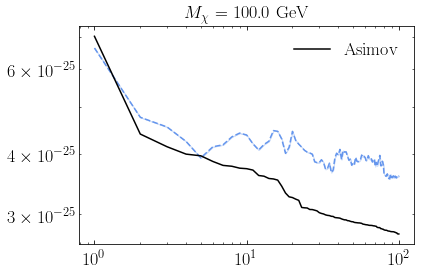

In [342]:
plt.plot(Nh_ary+1,np.percentile(limit_Nh,[50],axis=0)[0], color='cornflowerblue', ls='--')

# plt.plot(Nh_ary+1,np.mean(limit_Nh,axis=0), color='firebrick', ls='-',label='Mean')
# plt.plot(Nh_ary+1,np.exp(np.mean(np.log(limit_Nh),axis=0)), color='forestgreen', ls='-',label='Mean of log')

plt.fill_between(Nh_ary+1,np.percentile(limit_Nh,[16],axis=0)[0],np.percentile(limit_Nh,[84],axis=0)[0], alpha=0.1, color='cornflowerblue')
plt.fill_between(Nh_ary+1,np.percentile(limit_Nh,[2.5],axis=0)[0],np.percentile(limit_Nh,[97.5],axis=0)[0], alpha=0.2, color='cornflowerblue')

plt.plot(Nh_ary+1,np.percentile(limit_Nh_as,[50],axis=0)[0], color='black', ls='-',label='Asimov')

# plt.fill_between(Nh_ary+1,np.percentile(limit_Nh_as_16,[16],axis=0)[0],np.percentile(limit_Nh_as_84,[84],axis=0)[0], alpha=0.1, color='black')
# plt.fill_between(Nh_ary+1,np.percentile(limit_Nh_as_2p5,[16],axis=0)[0],np.percentile(limit_Nh_as_97p5,[84],axis=0)[0], alpha=0.1, color='black')

# plt.plot(Nh_ary+1,np.percentile(limit_Nh_as_test1,[50],axis=0)[0], color='black', ls='--')
# plt.plot(Nh_ary+1,np.percentile(limit_Nh_as_test2,[50],axis=0)[0], color='black', ls='--')
# plt.plot(Nh_ary+1,np.percentile(limit_Nh_as_test3,[50],axis=0)[0], color='black', ls='--')





plt.title("$M_\chi$ = " + str(marr[midx]) + " GeV")

plt.legend(frameon=False)
plt.yscale("log")
plt.xscale("log")

In [381]:
mc_dir = '/tigress/bsafdi/github/NPTF-working//NPTF-ID-Catalog/SimpleScan/data/FloatPS_indiv_floatDM_dm3/////////LL2_TSmx_lim_b_o'

obj_missing = []
imc_missing = []
for iobj in tqdm(range(100)):
    for imc in range(5):
        if not os.path.isfile(mc_dir + str(iobj) + '_mc' + str(imc) + '.npz'):
#         if not os.path.isfile("/tigress/bsafdi/github/NPTF-working//NPTF-ID-Catalog/SimpleScan/data/FloatPS_together_noDM/LL_inten_o"+str(iobj)+"_mc"+str(imc)+".npz"):
            obj_missing.append(iobj)
            imc_missing.append(imc)

100%|██████████| 100/100 [00:00<00:00, 292.50it/s]


In [369]:
np.save("obj_missing", obj_missing)
np.save("imc_missing", imc_missing)

In [382]:
max(imc_missing)

2

In [383]:
min(imc_missing)

2

In [384]:
imc_missing

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]